<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Monday 08 July 2019</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/UKESM-ConFire">github.com/douglask3/UKESM-ConFire</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of a global fire limitation model using Bayesian inference</h1>
<h2>Part 3: Posterior sampling</h2>
<br>
<br>
<sup>1, </sup> Megan Brown,
<sup>1,* </sup>Douglas Kelley, 
<sup>2 </sup>Ioannis Bistinas,
<sup>3 </sup>Rhys Whitley,
<sup>4 </sup>Chantelle Burton, 
<sup>1 </sup>Tobias Marthews, 
<sup>6, 7 </sup>Ning Dong
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Vrije Universiteit Amsterdam, Faculty of Earth and Life Sciences, Amsterdam, Netherlands
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>4 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>5 </sup>Centre for Past Climate Change and School of Archaeology, Geography and Environmental Sciences (SAGES), University of Reading, Reading, United Kingdom 
<br>
<sup>6 </sup>Department of Biological Sciences, Macquarie University, North Ryde, NSW 2109, Australia 
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
The previous notebook quantified the probability distribution of the model parameters of our global fire model. Here, we sample this distribution to obtain a number of key measures of fire regime: burnt area, and the value, limitation and sensitivity of fuel, moisture, ignitions and suppression controls.
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

# Load libraries

In [168]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   libs.plot_maps    import *

## Input information

Modify 'title_output' and you'll also need to mannually mkdir of the title_output in respective 'figures' folder. You can change which input are used to put into the model by changing the file dictionaries.
JULES data only runs from July 2000 to Dec 2010, so I created a separate dictionary for that (below). If you use this, you'll also have to change the output and figure directory.


Data in 'retrieved_codes/2000-2014' and 'jul2000-2014' has already been scaled and adjusted (e.g. lightning, RH).
The jul2000-2014 files have 168 time points and start at July 2000 and go up to June 2014, like the obs files. This makes them compatible when mixing up obs + UKESM runs.

In [169]:
dir = '../outputs/amazon_region/'

files = {'soilwMax'           : 'vegetation/MaxOverMean_soilw.0-10cm.gauss.2000-2019.nc',
         'soilw'              : 'climate/soilw.0-10cm.gauss.2000-2019.nc',
         'precip'             : 'climate/precip2001-2019.nc',
         'emc'                : 'climate/emc-2001-2019.nc',
         'treeCover'          : 'vegetation/treecover-2001-June2018.nc',
         'lightning'          : 'climate/lightning2001-2019.nc',
         'pasture'            : 'human/pasture2001-2019.nc',
         'population_density' : 'human/population_density-PD_HYDEv3.2_2001-2018.nc',
         'cropland'           : 'human/cropland2001-2019.nc',
         'vegcover'           : 'vegetation/vegcover-2001-June2018.nc',
         'burnt_area'         : 'burnt_area-GFED4s_2.5degree_2000-2016.nc',
         'firecount'          : 'fire_counts/firecount_TERRA_M__T.nc'}


In [170]:
param_files  = ['../outputs/params-testburnt_area.csv', '../outputs/params-testfirecount.csv']
exponates    = [False, True]
variables    = ["burnt_area", "firecount"]
title_output = 'constant_post_2018'

fire_Season = [7, 8, 9]


# Toggle plots on/off
fig = False
dir_fig = '../figs/burnt_area/' + title_output + '/'

outfile = '../outputs/burnt_area' + title_output + '/'
File = title_output + '.nc'

Open data. The model takes data in the same dict class as above.

In [171]:
##open data
input_data = {}
for key, file in files.items():
    data = iris.load_cube(dir + file)
    input_data[key] = data


params = [pd.read_csv(param_file) for param_file in param_files]
#for param in params: print(param.head())

Plotting annual averages just to make sure the data looks senible

In [172]:
ntime = max([dat.shape[0] for __, dat in input_data.items()])

ntime = 0 
for key, dat in input_data.items(): 
    if dat.shape[0] > ntime:
        ntime = dat.shape[0]
        temp = dat.copy()

for key, dat in input_data.items():
    ntime_d = dat.shape[0]
    if ntime_d < ntime:
        temp.data[0:ntime_d] = dat.data
        for mn in range(ntime_d, ntime):
            ntime_d_lastYr = ntime_d - 12
            temp.data[mn] = dat.data[ntime_d_lastYr]
            
        input_data[key] = temp.copy()

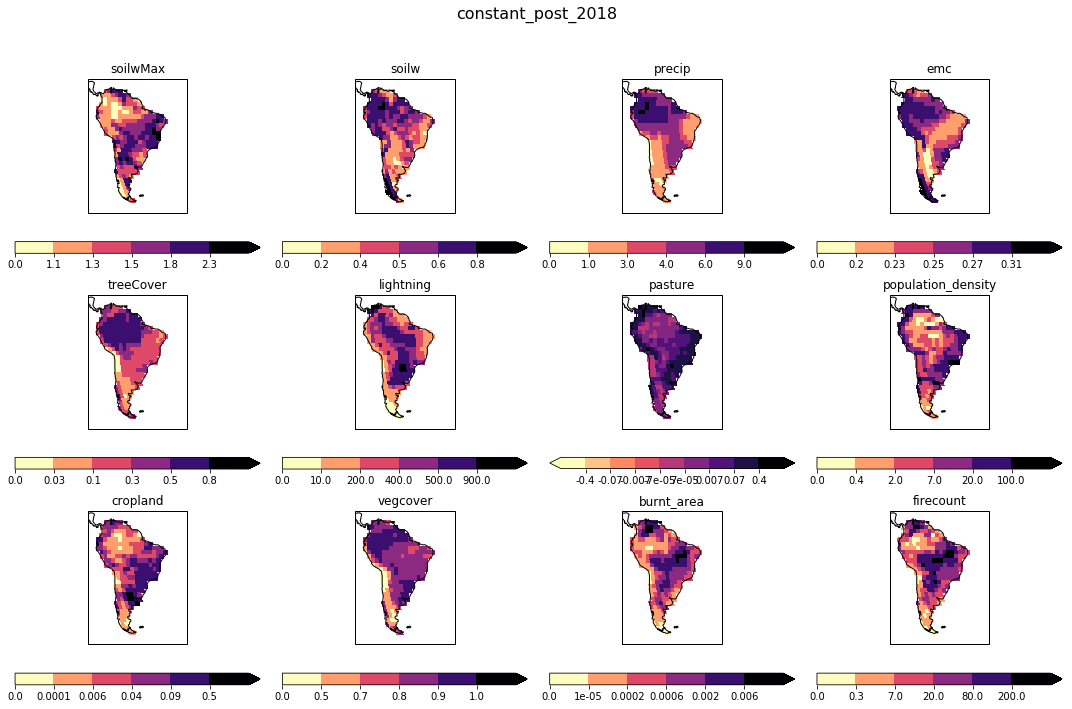

In [173]:
nd = 0

plt.figure(figsize = (15, 10))

for key, dat in input_data.items():
    nd = nd + 1
    dat = dat.collapsed('time', iris.analysis.MEAN)
    dat.long_name = key
    plot_lonely_cube(dat, 3, 4, nd, cmap = 'magma_r', levels = None)
    plt.suptitle(title_output, fontsize=16)
    plt.subplots_adjust(top=0.88)
if fig:
    plt.savefig(dir_fig + "input_data.png")

## The model
The model is now defined. See documentation paper in NCC for full model equations. This could be moved into a library at some point, but I've defined it here so you can have a proper look.

The model calculates a number of things needed to predict burnt area, and a few metric (potential limitation and sensitivity) on the fly. The things needed to calculate burnt area are ``ConFIRE.``:

* **Controls**:
    * ``fuel``: fuel continuity
    * ``moisture``: fuel mositure content
    * ``ignitions``: potential ignitions
    * ``suppression``: human fire suppression and landscape fragmentation

* **Limitation from controls**, the maximum allowed fire considering limitation from:
    * ``standard_fuel``:  fuel
    * ``standard_moisture``:  moisture
    * ``standard_ignitions``:  ignitions
    * ``standard_suppression``:  suppression

* and ``burnt_area``: burnt area from all limitations

Things calculated on the fly are:

* **Potential limitation**, the increase in burnt area if limitation where removed from:
    * ``potential_fuel``:  fuel
    * ``potential_moisture``:  moisture
    * ``potential_ignitions``:  ignitions
    * ``potential_suppression``:  suppression

* **Sensitvity**, the rate of change in burnt area for a given control, relative to the maximum possible rate of change for that controls:
    * ``sensitivity_fuel``:  fuel
    * ``sensitivity_moisture``:  moisture
    * ``sensitivity_ignitions``:  ignitions
    * ``sensitivity_suppression``:  suppression

In [176]:
class ConFIRE(object):
    def __init__(self, data, params, exponant = False):
        """
        Initalise parameters and calculates the key variables needed to calculate burnt area.
        """
        self.params = params


        ## finds controls
        self.fuel = self.control_fuel(data['vegcover'], data['soilwMax'], self.params['fuel_pw'],
                                      self.params['fuel_pg'])
        
        self.emcw = self.emc_weighted(data['emc'], data["precip"], self.params['wd_pg'])
        
        self.moisture = self.control_moisture(data['soilw'], self.emcw, data['treeCover'], data["precip"],
                                              self.params['cM'], self.params['cMT'], self.params['cMP'])

        self.ignitions = self.control_ignitions(data['lightning'], data['pasture'], data['population_density'],
                                              self.params['cP'], self.params['cD1'])

        self.suppression = self.control_suppression(data['cropland'], data['population_density'],
                                              self.params['cD2'])

        ## calculates limiting factor of each control.
        self.standard_fuel        = self.sigmoid(self.fuel       ,
                                            self.params[       'fuel_x0'], self.params[       'fuel_k'])  
        
        self.standard_moisture    = self.sigmoid(self.moisture   ,
                                            self.params[   'moisture_x0'], -self.params[   'moisture_k'])
        self.standard_ignitions   = self.sigmoid(self.ignitions   ,
                                            self.params[  'ignition_x0'], self.params[  'ignition_k'])
        self.standard_suppression = self.sigmoid(self.suppression,
                                            self.params['suppression_x0'], -self.params['suppression_k'])

        ## burnt area us just limitation of each control muliplied together.
        self.burnt_area = self.standard_fuel * self.standard_moisture * self.standard_ignitions * self.standard_suppression * self.params['max_f']

        if exponant:
            self.burnt_area.data =  -(1/self.params['exp_scale']) * np.log(1 - self.burnt_area.data) 
        self.standard_moisture    = self.standard_moisture    / self.sigmoid(0.0, self.params['moisture_x0'],
                                                 -self.params['moisture_k'])
        self.standard_suppression = self.standard_suppression / self.sigmoid(0.0, self.params['suppression_x0'],
                                                 -self.params['suppression_k'])

        ## if the inputs are iris cubes, we can add some useful metadata
        try:
            self.burnt_area.long_name = "burnt_area"

            self.fuel.long_name = "fuel continuity"
            self.fuel.units = '1'

            self.moisture.long_name = "moisture content"
            self.moisture.units = '1'

            self.ignitions.long_name = "ignitions"
            self.ignitions.units = 'km-2'

            self.suppression.long_name = "suppression"
            self.suppression.units = '1'

            self.standard_fuel.long_name = "standard_fuel"
            self.standard_moisture.long_name = "standard_moisture"
            self.standard_ignitions.long_name = "standard_ignitions"
            self.standard_suppression.long_name = "standard_suppression"

            self.standard_fuel.units = '1'
            self.standard_moisture.units = '1'
            self.standard_ignitions.units = '1'
            self.standard_suppression.units = '1'
        except:
            pass


    def control_fuel(self, vegcover, alphaMax, fuel_pw, fuel_pg):
        """
        Definition to describe fuel load: while return the input; capability to be modified later.
        """
        return (vegcover**(fuel_pw+1)) * (fuel_pg * (alphaMax-1) + 1) / (1 + fuel_pg)
    
    def emc_weighted(self, emc, precip, wd_pg):
        try:
            wet_days = 1 - np.exp(-wd_pg * precip)
            emcw = wet_days + (1-wet_days) * emc
        except:
            emcw = emc.copy()
            emcw.data  = 1 - np.exp(-wd_pg * precip.data)
            emcw.data = emcw.data + (1-emcw.data) * emc.data
        return(emcw)

    def control_moisture(self, alpha, emc, treeCover, precip, cM, cMT, cMP):
        """
        Definition to describe moisture
        """
        return (alpha + cM*emc + cMT * treeCover + cMP * precip) / (1 + cM + cMT + cMP)


    def control_ignitions(self, lightning, pasture, population_density, cP, cD1):
        """
        Definition for the measure of ignition
        """
        ignite = lightning + cP*pasture + cD1*population_density
        
        return ignite


    def control_suppression(self, cropland, population_density, cD2):
        """
        Definition for the measure of fire supression
        """
        return cropland + cD2*population_density

        """
        Defines potential limitation for each control in turn
        """
    def potential_fuel(self):
        return self.potential(self.standard_fuel, "potential_fuel")


    def potential_moisture(self):
        return self.potential(self.standard_moisture, "potential_moisture")


    def potential_ignitions(self):
        return self.potential(self.standard_ignitions, "potential_ignitions")


    def potential_suppression(self):
        return self.potential(self.standard_suppression, "potential_suppression")


    def sensitivity_fuel(self):
        return self.sensitivity(self.fuel, self.params['fuel_x0'], self.params['fuel_k'],
                                self.standard_fuel, "sensitivity_fuel")

    """
    Defines sensitivity for each control in turn
    """
    def sensitivity_moisture(self):
        return self.sensitivity(self.moisture, self.params['moisture_x0'], -self.params['moisture_k'],
                                self.standard_moisture, "sensitivity_moisture")


    def sensitivity_ignitions(self):
        return self.sensitivity(self.ignitions, self.params['ignition_x0'], self.params['ignition_k'],
                                self.standard_ignitions, "sensitivity_ignitions")


    def sensitivity_suppression(self):
        return self.sensitivity(self.suppression, self.params['suppression_x0'], -self.params['suppression_k'] ,
                                self.standard_suppression, "sensitivity_suppression")


    def sensitivity(self, x, x0, k, fi, long_name = None):

        gradient = self.gradient(x, x0, k)
        sens = gradient * self.control_removal(fi)

        try: sens.units = '1'
        except: pass

        if long_name is not None:
            try: sens.long_name = long_name
            except: pass
        return sens


    def control_removal(self, fi):
        return self.burnt_area/fi


    def potential(self, fi, long_name = None):
        out = fi.copy()
        out.data = self.burnt_area.data * ((1/out.data) - 1)

        try: out.units = '1'
        except: pass

        if long_name is not None:
            try: out.long_name = long_name
            except: pass
        return out


    def gradient(self, x, x0, k, dx = 0.0001):

        f1 = self.sigmoid(x + dx, x0, k)
        f2 = self.sigmoid(x - dx, x0, k)

        n1 = self.sigmoid(x0 + dx, x0, k)
        n2 = self.sigmoid(x0 - dx, x0, k)

        try:
            f1 = (f1 - f2)/(n1 - n2)
        except:
            f1.data = (f1.data - f2.data) / (n1.data - n2.data)

        return f1


    def sigmoid(self, x, x0,k):
        """
        Sigmoid function to describe limitation using tensor
        """
        try:
            out = x.copy()
            out.data = -k*(x.data - x0)
            out.data = 1.0/(1.0 + np.exp(out.data))
            x = out
        except:
            x = -k * (x - x0)
            x = 1.0/(1.0 + np.exp(x))
        return x

#### Check that everything is working okay
Here, we run the model with the median of each parameter and plot each of the outputs mentioned above to make sure everything is happy

In [177]:
# We're using the row which has minimum sigma
models = [ConFIRE(input_data, param.loc[0], exponate) for param, exponate in zip(params, exponates)]#param["sigma"].idxmin()]

### Plotting

#### Fire measure

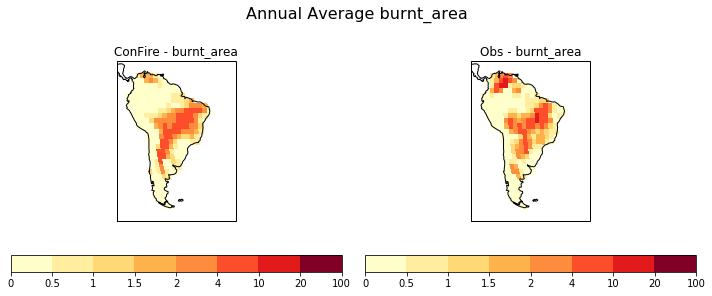

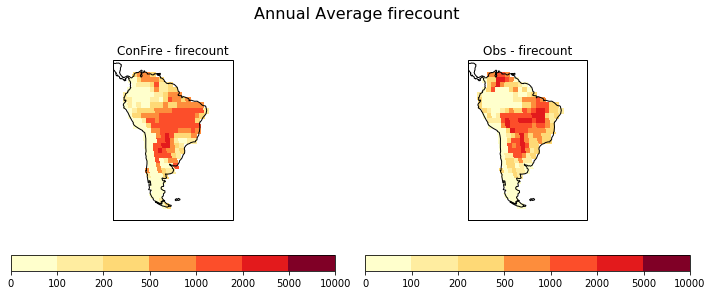

In [178]:

levels_var = [[0, 0.5, 1, 1.5, 2, 4, 10, 20, 100], [0, 100, 200, 500, 1000, 2000, 5000, 10000]]
scales = [100, 1]
def plot_fire_month(mnths = None, nmth_ys = 12):
    for model, variable, level, scale in zip(models, variables, levels_var, scales):
        plt.figure(figsize = (10, 7.5))
        if mnths is None: mnths = np.arange(0, 12*15)
            
        sim = model.burnt_area[mnths].collapsed('time', iris.analysis.MEAN)
        sim.long_name = "ConFire - " + variable
        sim.data = sim.data * nmth_ys * scale

        plot_lonely_cube(sim, 2, 2, 1, levels = level, cmap = "brewer_YlOrRd_09")

        #gfed = iris.load_cube('../outputs/amazon_region/burnt_area-GFED4s_2.5degree_2000-2016.nc')
        mod = input_data[variable].collapsed('time', iris.analysis.MEAN)*12 * scale
        mod.long_name = "Obs - " + variable
        plot_lonely_cube(mod, 2, 2, 2, levels = level, cmap = "brewer_YlOrRd_09")

        plt.subplots_adjust(top=0.88)
        plt.suptitle("Annual Average " + variable, fontsize=16)
        plt.subplots_adjust(top=0.88)

        if fig:
            plt.savefig(dir_fig + variable + '.png')
            
plot_fire_month()

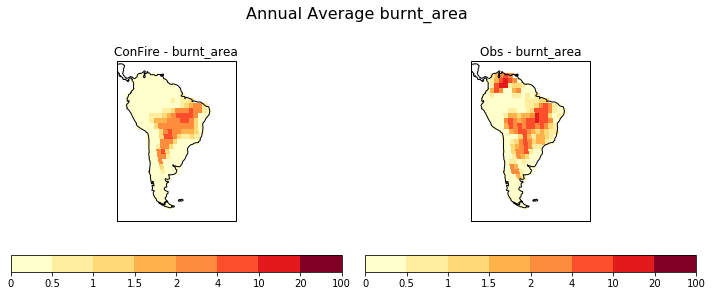

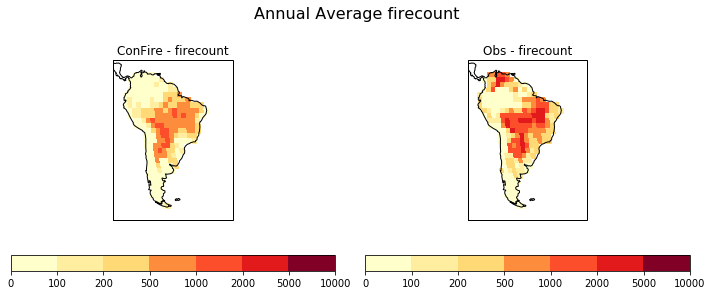

In [179]:
fire_Season = np.array([7, 8, 9])

fire_Season = np.array([fire_Season + yr*12 for yr in range(0, 15)]).flatten()
    
plot_fire_month(fire_Season, 3)

#### Controls

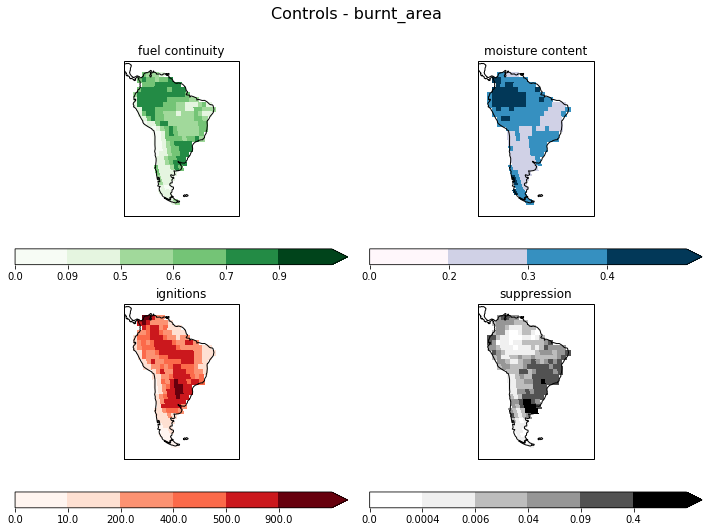

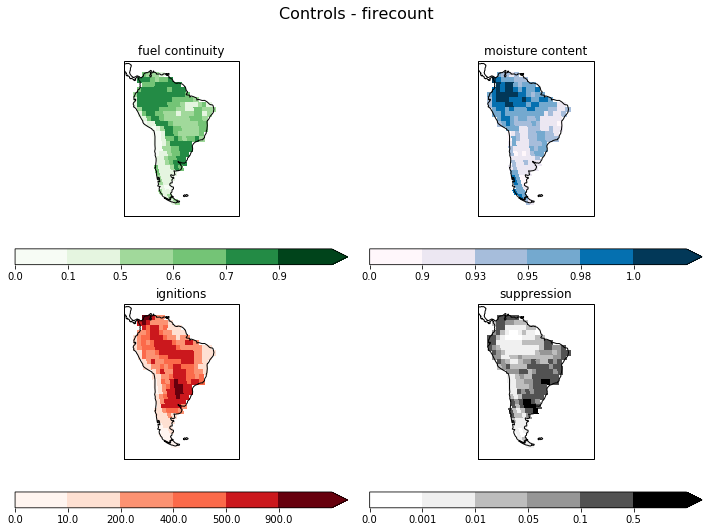

In [180]:
cmap_fuel = 'brewer_Greens_09'
cmap_moisture = 'brewer_PuBu_09'
cmap_ignitions = 'brewer_Reds_09'
cmap_suppression = 'brewer_Greys_09'

levels_frac = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
levels_frac = None#[0,0.45,  0.5, 0.55, 1.0]
levels_ignitions = None
    
def plotModComponet(comp, n, mnths = None, name = None, levels = None, scale = None, cmap = "brewer_YlOrRd_09",
                    *args, **kws):
    if mnths is None: mnths = np.arange(0, 12*15)
    
    comp = comp[mnths].collapsed('time', iris.analysis.MEAN)
    if scale is not None: comp.data = comp.data * scale
    if name  is not None: comp.long_name = name
    plot_lonely_cube(comp, 2, 2, n, levels = levels, cmap = cmap, *args, **kws)

def plot_fire_month(**kw):
    for model, variable in zip(models, variables):   
        plt.figure(figsize = (10, 7.5))
        plotModComponet(model.fuel, 1, cmap = cmap_fuel, levels = levels_frac, **kw)
        plotModComponet(model.moisture, 2, cmap = cmap_moisture, levels = levels_frac, **kw)
        plotModComponet(model.ignitions, 3, cmap = cmap_ignitions, levels = levels_ignitions, **kw)
        plotModComponet(model.suppression, 4, cmap = cmap_suppression, levels = levels_frac, **kw)
        plt.suptitle('Controls - ' + variable, fontsize=16)
        plt.subplots_adjust(top=0.88)
        if fig:
            plt.savefig(dir_fig + 'controls.png')
            
plot_fire_month()

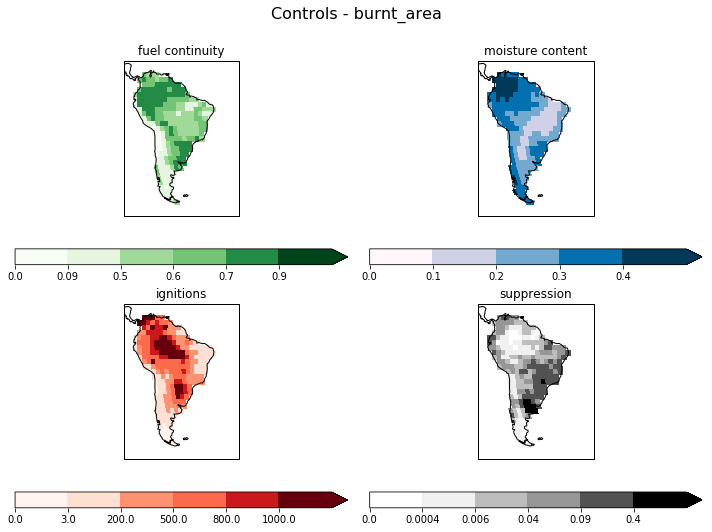

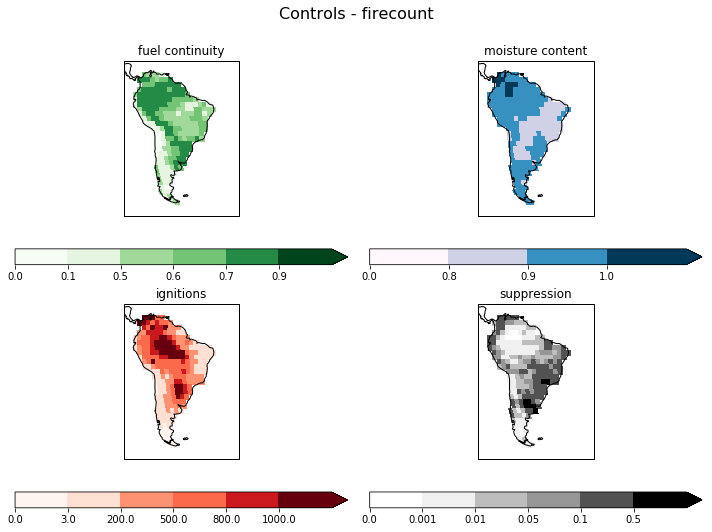

In [181]:
plot_fire_month(mnths = fire_Season)

#### Standard Limitation

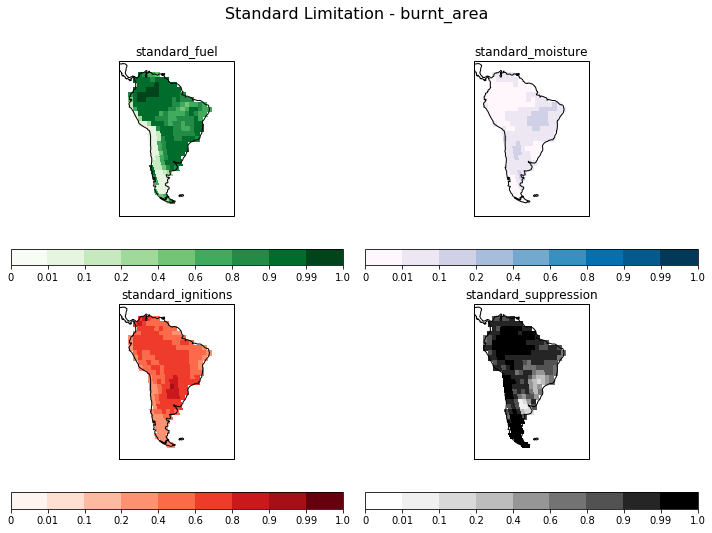

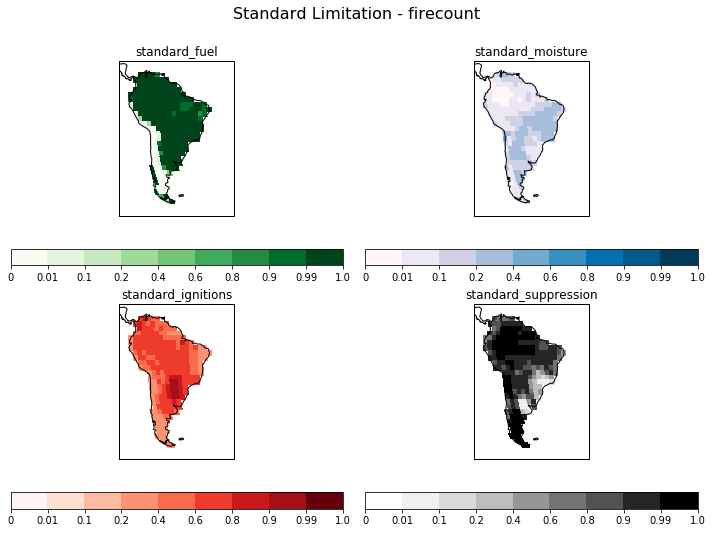

In [182]:
levels = [0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0]
def plot_fire_month(**kw):
    for  model, variable in zip(models, variables): 
        plt.figure(figsize = (10, 7.5))
        plotModComponet(model.standard_fuel, 1, cmap = cmap_fuel, levels = levels, **kw)
        plotModComponet(model.standard_moisture, 2, cmap = cmap_moisture, levels = levels, **kw)
        plotModComponet(model.standard_ignitions, 3, cmap = cmap_ignitions, levels = levels, **kw)
        plotModComponet(model.standard_suppression, 4, cmap = cmap_suppression, levels = levels, **kw)
        plt.suptitle('Standard Limitation - ' + variable, fontsize=16)
        plt.subplots_adjust(top=0.88)
        if fig:
            plt.savefig(dir_fig + 'standard_limitation.png')
            
plot_fire_month()

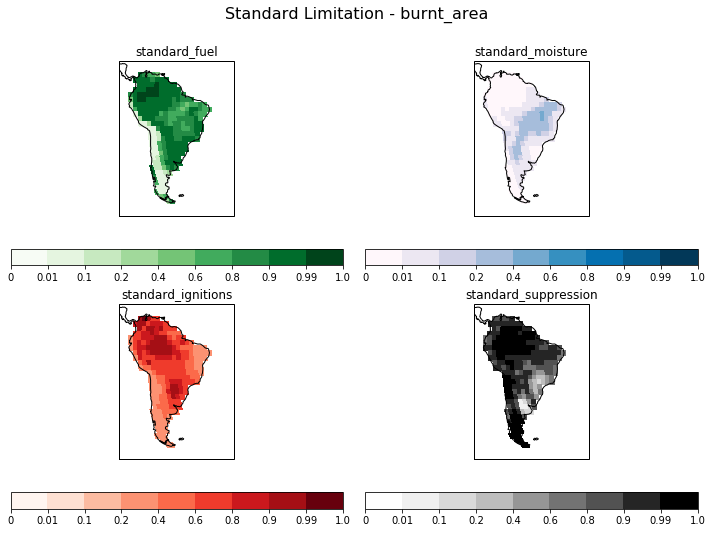

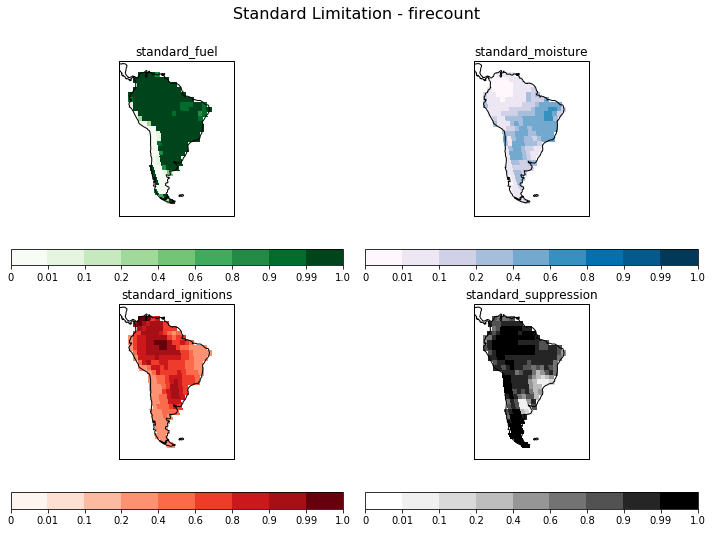

In [183]:
plot_fire_month(mnths = fire_Season)

#### Potential limitation

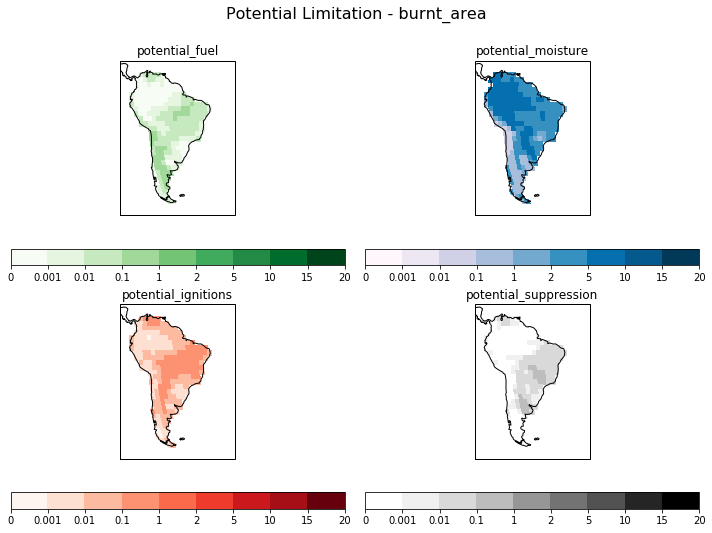

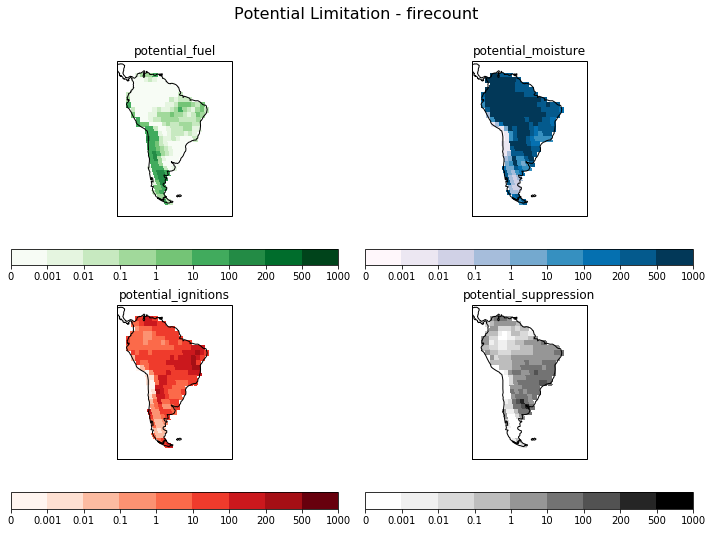

In [184]:
levels_var = [[0, 0.001, 0.01, 0.1, 1, 2, 5, 10, 15, 20], [0, 0.001, 0.01, 0.1, 1, 10, 100, 200, 500, 1000]]
def plot_fire_month(**kw):
    for model, variable, levels, scale in zip(models, variables, levels_var, scales):
        plt.figure(figsize = (10, 7.5))
        plotModComponet(model.potential_fuel(), 1, levels = levels, scale = scale,
                        cmap = cmap_fuel, **kw)
        plotModComponet(model.potential_moisture(), 2, levels = levels, scale = scale,
                        cmap = cmap_moisture, **kw)
        plotModComponet(model.potential_ignitions(), 3, levels = levels, scale = scale,
                        cmap = cmap_ignitions, **kw)
        plotModComponet(model.potential_suppression(), 4, levels = levels, scale = scale,
                        cmap = cmap_suppression, **kw)
        plt.suptitle('Potential Limitation - ' + variable, fontsize=16)
        plt.subplots_adjust(top=0.88)
        if fig:
            plt.savefig(dir_fig + 'potential_limitation.png')

plot_fire_month()

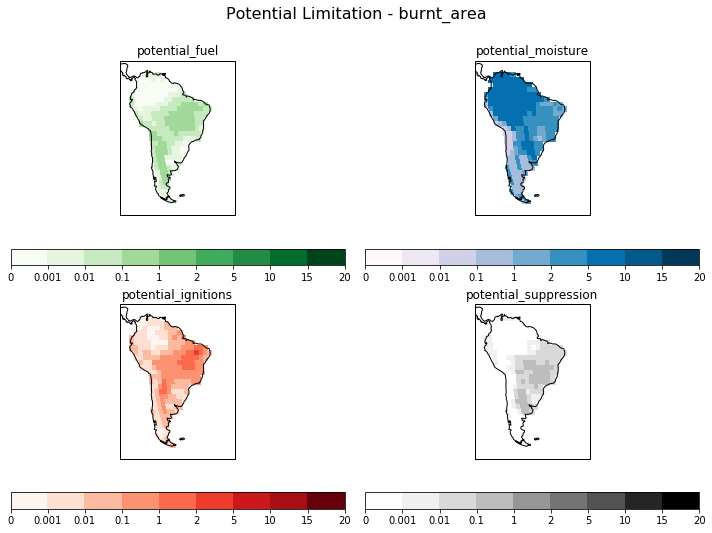

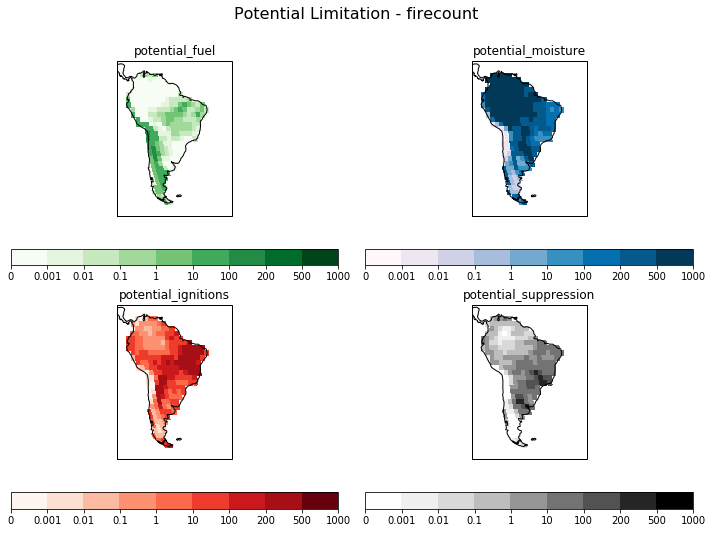

In [185]:
plot_fire_month(mnths = fire_Season)

#### Sensitivty

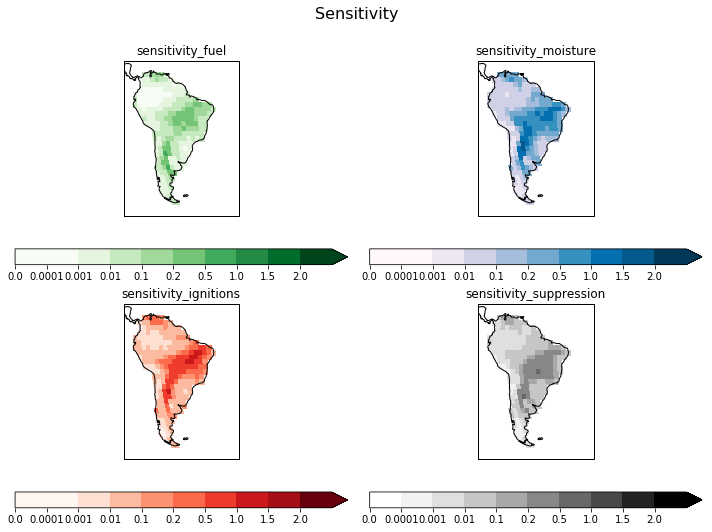

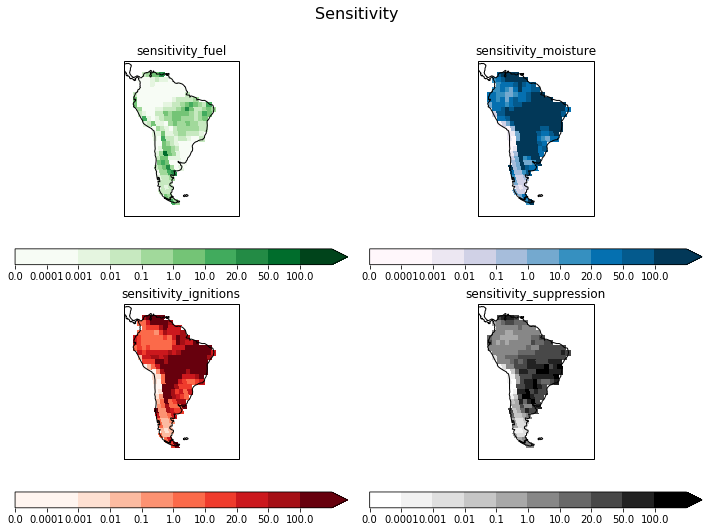

In [186]:
def plot_fire_month(**kw):
    for model, variable, levels, scale in zip(models, variables, levels_var, scales):
        plt.figure(figsize = (10, 7.5))
        levels = np.array(levels)/10.0
        plotModComponet(model.sensitivity_fuel(), 1, scale = scale, levels = levels,
                        cmap = cmap_fuel, extend = 'max')
        plotModComponet(model.sensitivity_moisture(), 2, scale = scale, levels = levels,
                        cmap = cmap_moisture, extend = 'max')
        plotModComponet(model.sensitivity_ignitions(), 3, scale = scale, levels = levels,
                        cmap = cmap_ignitions, extend = 'max')
        plotModComponet(model.sensitivity_suppression(), 4, scale = scale, levels = levels,
                        cmap = "Greys", extend = 'max')
        plt.suptitle('Sensitivity', fontsize=16)
        plt.subplots_adjust(top=0.88)
        if fig:
            plt.savefig(dir_fig + 'sensitivity.png')
            
plot_fire_month()

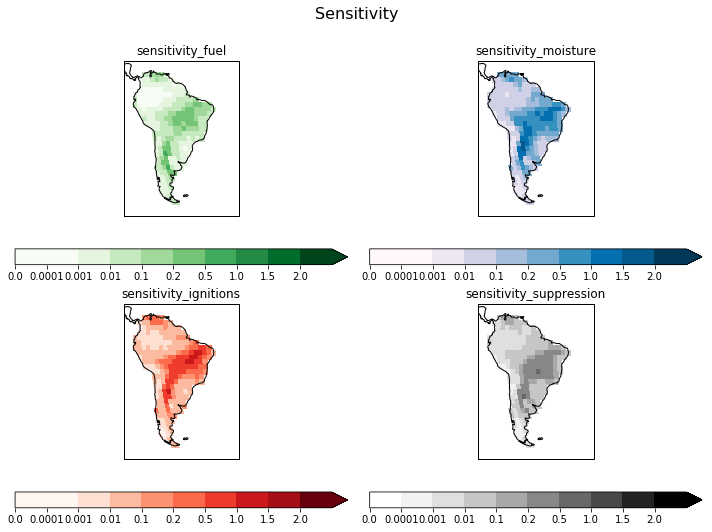

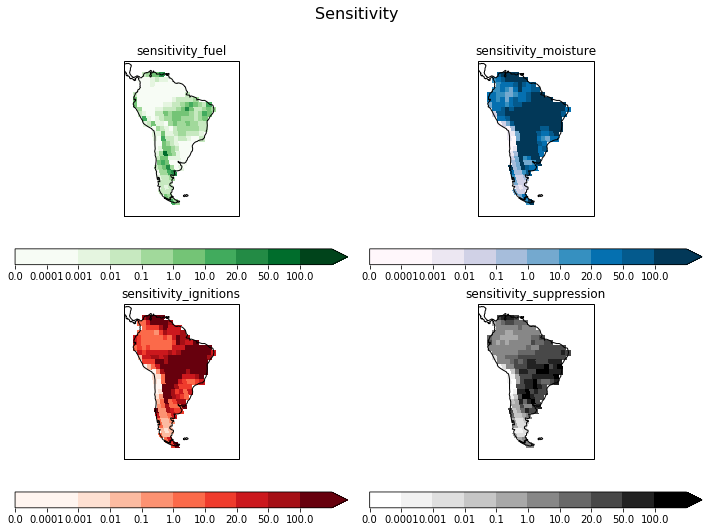

In [187]:
plot_fire_month(mnth = fire_Season)

#### Bootstrapping

In [132]:
n_posterior = params.shape[0]
n_posterior_sample = 10
ngap = int(n_posterior/n_posterior_sample)

output_controls = True
output_standard_limitation = True
output_potential_limitation = True
output_sensitivity = True

output_dir = '../outputs/sampled_posterior_ConFire_solutions/'
try: os.mkdir(output_dir)
except: pass
    
output_dir = output_dir + title_output +'/'
try: os.mkdir(output_dir)
except: pass

for i in range(0, n_posterior, ngap):
    model = ConFIRE(input_data, params.iloc[i])
    cubes = [model.burnt_area]
    
    if output_controls:
        cubes = cubes + [model.fuel, model.moisture, 
                         model.ignitions, model.suppression]
        
    if output_standard_limitation:
        cubes = cubes + [model.standard_fuel, model.standard_moisture, 
                         model.standard_ignitions, model.standard_suppression]
    
    if output_potential_limitation:
        cubes = cubes + [model.potential_fuel(), model.potential_moisture(),                 
                         model.potential_ignitions(), model.potential_suppression()]
    
    if output_sensitivity:
        cubes = cubes + [model.sensitivity_fuel(), model.sensitivity_moisture(),                  
                         model.sensitivity_ignitions(), model.sensitivity_suppression()]
    
    cubes = iris.cube.CubeList(cubes) 
    
    outFile = output_dir + 'sample_no_' + str(i) +'.nc'
    iris.save(cubes, outFile)